In [67]:
import polars as pl
import matplotlib.pyplot as plt

In [68]:
with open('raw/session.txt', 'r') as f:
    lines = f.readlines()

In [132]:
import re

def parse(lines):
    pattern = re.compile(r'(\d+)m(\d+.\d+)s')

    rows = []
    
    acc = None
    file = None
    success = True
    for line in lines:
        if line.startswith('SRR'):
            acc = line.strip()
        if line.endswith('download\n'):
            file = line.split()[0].strip()
        if line.startswith('curl: (22)'):
            success = False
        if line.startswith('real'):
            realtime = line.split()[1].strip()
            match = pattern.match(realtime)
            minutes = int(match.group(1))
            seconds, miliseconds = (int(x) for x in match.group(2).split('.'))
            time = 60_000 * minutes + 1000 * seconds + miliseconds
            rows.append(dict(
                acc=acc,
                file=file,
                ms=time,
                succ=success
            ))
            success = True
    return rows

In [133]:
df = pl.DataFrame(parse(lines))
df

acc,file,ms,succ
str,str,i64,bool
"""SRR8256072""","""FASTQ.GZ""",3031,true
"""SRR8256072""","""FASTQ.GZ""",2489,true
"""SRR8256072""","""FASTQ.GZ""",2467,true
"""SRR8256072""","""FASTQ""",167893,true
"""SRR8256072""","""FASTQ""",168267,true
…,…,…,…
"""SRR32499888""","""FASTQ""",2350,false
"""SRR32499888""","""FASTQ""",2354,false
"""SRR32499888""","""SRA""",1026149,true


In [134]:
df_succ = df.filter(pl.col('succ') == 'true').drop('succ')

In [135]:
df_means = df_succ.group_by('acc', 'file').agg([
    pl.col('ms').mean().alias('mean'),
    pl.col('ms').std().alias('std'),
])
df_means

acc,file,mean,std
str,str,f64,f64
"""SRR32296246""","""SRA""",191764.666667,55350.356641
"""SRR32499888""","""SRA""",1.10447e6,120641.567766
"""SRR8256072""","""FASTQ.GZ""",2662.333333,319.464135
"""SRR32296246""","""FASTQ.GZ""",79313.666667,38261.606047
"""SRR8256072""","""SRA""",6059.666667,94.299169
"""SRR32499888""","""FASTQ.GZ""",483921.333333,69067.503106
"""SRR8256072""","""FASTQ""",169849.0,3069.699008


In [136]:
df_grp = df_succ.group_by('acc').mean().to_dict()
mapping = {}
for i in range(len(df_grp['acc'])):
    mapping[df_grp['acc'][i]] = df_grp['ms'][i]

accs = sorted(list(df_means['acc'].unique()), key=lambda x: mapping[x])

In [137]:
from sra_explorer import SRAExplorer

bases_count = []

for acc in accs:
    for metadata in SRAExplorer(acc):
        if metadata.runs.acc == acc:
            bases_count.append(metadata.runs.total_bases / 1024 ** 3)

In [155]:
sizes_map = {
    'SRR8256072': {
        'SRA': 124,
        'FASTQ': 155,
        'FASTQ.GZ': 184,
    },
    'SRR32296246':{
        'SRA': 3871,
        'FASTQ.GZ': 3890,
    },
    'SRR32499888': {
        'SRA': 25804,
        'FASTQ.GZ': 26870,
    },
}

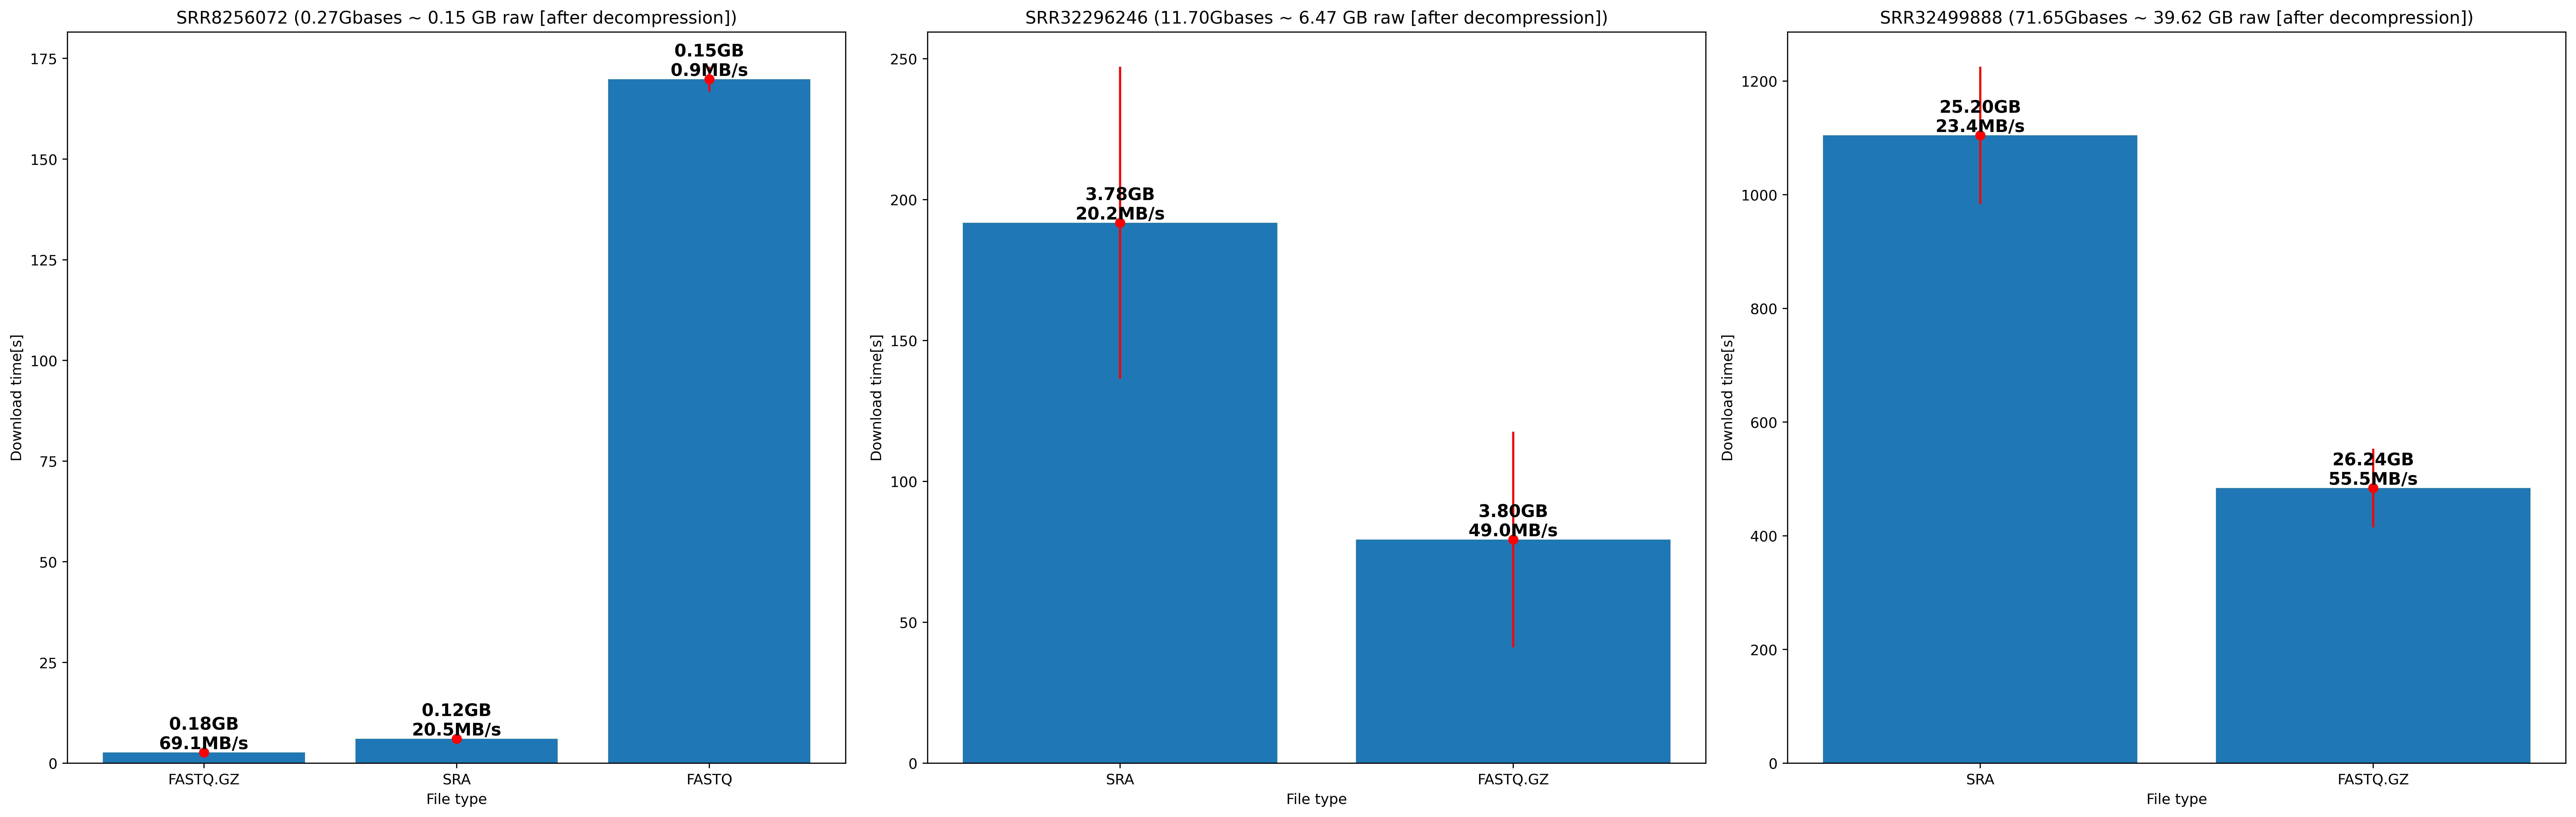

In [181]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 8), dpi=500)

for i, acc in enumerate(accs):
    tmp = df_means.filter(pl.col('acc') == acc)
    bars = axes[i].bar(tmp['file'], tmp['mean'] / 1000)
    axes[i].errorbar(tmp['file'], tmp['mean'] / 1000, yerr=tmp['std'] / 1000, fmt="o", color="r")
    axes[i].set_title(f'{acc} ({bases_count[i]:.2f}Gbases ~ {bases_count[i] * 0.553:.2f} GB raw [after decompression])')
    axes[i].set_ylabel('Download time[s]')
    axes[i].set_xlabel('File type')

    sizes = [sizes_map[a][f] for a, f in tmp['acc', 'file'].rows()]
    speeds = [sizes_map[a][f] / (t / 1000) for a, f, t in tmp['acc', 'file', 'mean'].rows()]
    for size, speed, bar in zip(sizes, speeds, bars):
        
        height = bar.get_height()
        axes[i].text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{size / 1024:.2f}GB\n{speed:.1f}MB/s',
            ha="center",
            va="bottom",
            fontsize=12,
            fontweight="bold"
        )
    plt.tight_layout()
plt.savefig('raw_sra_vs_fastq_download_speed.png')